# TP - Multi-agent deep reinforcement learning algorithm

Written by Maxime Toquebiau. Code adapted from https://github.com/koulanurag/minimal-marl/tree/main/.

We will implement four different mutli-agent deep reinforcement learning (MADRL) algorithms:
* Independent Deep Q-Network (DQN)
* Multi-agent Deep Deterministic Policy Gradient (MADDPG)
* Value Decomposition Network (VDN)
* QMIX

### Instructions:
* Read all cells and try to understand the code. Ask the supervisor for help when something is not clear to you.
* Complete the code where required (noted <font color='red'>TODO</font> and `-- TODO --` in comments) based on the given information, the original papers, etc. **IMPORTANT WARNING:** training each model will take time (around 20 minutes for 20000 episodes). So, before launching the training, **call the supervisor to check if your code is right**. Then, run training and start working on the next cell during the training time. 
* Answer the questions (noted <font color='red'>QUESTION</font>) about the techniques and results. 

**Start by installing the required dependencies** by running the following cell. If your machine is equipped with a GPU, you can install torch without the `--index-url https://...` flag.

In [ ]:
!pip install gym pillow matplotlib tqdm
!pip install torch --index-url https://download.pytorch.org/whl/cpu

### Create the learning environment

We use the Predator-Prey task from the Multi-Agent-Gym environment. The task requires agents (in blue) to catch preys (in red). To catch a prey, agents have to be two or more in orthogonally adjacent cells of the prey. Agents only observe the 5x5 square of cells around them. 

In [ ]:
from env.ma_gym.pred_prey import PredatorPrey

env = PredatorPrey(n_agents=3, n_preys=2, penalty=0.0, grid_shape=(12, 12))
env.seed(100)
env.reset()
env.render()

This function will plot the results.

In [2]:
import matplotlib.pyplot as plt

def plot_logs(logs):
    for l in logs:
        plt.plot(l["episode"], l["score"], label=l["name"])
    
    plt.xlabel("Training episode #")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

## Independent Deep Q-Network

The Independent Deep Q-Network (IDQN) is the deep version of the Independent Q-Learning algorithm ([Tan, 1993](https://web.media.mit.edu/~cynthiab/Readings/tan-MAS-reinfLearn.pdf)) that introduced a multi-agent algorithm where each agent learns a Q-function without taking care of other agents. In other words, the other agents are considered part of the environment and the agent learns a policy without considering the fact that other agents are in the environment. 

**However**, while agents are described as "independent", this algorithm is *not* completely decentralised. Already in his 1993 paper, Tan described three strategies to improve the efficiency of training independent Q-learning agents by exploiting the fact that training is done by a single central algorithm. 

<font color='red'>QUESTION:</font> Look at Tan's 1993 paper (linked above) and find these three ways to improve independent Q-learning agents. Describe them succintly here:

1. ...
2. ...
3. ...

In the following, we will look at similar techniques, often implemented in modern MADRL algorithms.

### Concurrent Experience Replay

If agents were trained in a completely decentralised way, they would each sample transitions separately for updating their strategy. Thus, they would likely use different environment steps to train on. This can have a detrimental effect, with agents learning from different events and thus producing different behaviours. 

For this reason, it is now common to **train all agents on the same environment steps**, as formally introduced as *"Concurrent Experience Replay"* in [Omidshafiei et al. (2017)](https://proceedings.mlr.press/v70/omidshafiei17a.html). Of course, this does not mean that agent train on the exact same data, they will only sample transitions from the same time steps in the environment, mearning they will from the same events. Note that this is only possible because we train the agents with a single central algorithm that handles training for all agents. This central algorithm is therefore able to sample concurrent time steps for all agents. In a completely decentralised setting, agents would likely have no way of sharing which transitions they use for training to synchronise their learning.

The following cell implements two buffer memories, one where agents sample transitions separately (`ReplayBuffer`) and one where they sample concurrent transitions (`ConcurrentReplayBuffer`). See that, in this code, the concurrent buffer is simpler to implement because transitions are stored in a concurrent fashion. 

In [ ]:
import collections
import random
import torch


class ReplayBuffer:
    def __init__(self, buffer_limit, num_agents):
        self.buffer = collections.deque(maxlen=buffer_limit)
        self.num_agents = num_agents

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        """
        Each agent samples its own n transitions independently,
        but output tensors are shaped as [n, num_agents, ...].
        """
        s_all_agents, a_all_agents, r_all_agents, s_prime_all_agents, done_mask_all_agents = [], [], [], [], []

        for agent_idx in range(self.num_agents):
            mini_batch = random.sample(self.buffer, n)
            s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

            for transition in mini_batch:
                s_all, a_all, r_all, s_prime_all, done_all = transition
                s, a, r, s_prime, done = (
                    s_all[agent_idx],
                    a_all[agent_idx],
                    r_all[agent_idx],
                    s_prime_all[agent_idx],
                    done_all[agent_idx],
                )

                s_lst.append(s)
                a_lst.append(a)
                r_lst.append(r)
                s_prime_lst.append(s_prime)
                done_mask_lst.append(1.0 - float(done))

            s_all_agents.append(s_lst)
            a_all_agents.append(a_lst)
            r_all_agents.append(r_lst)
            s_prime_all_agents.append(s_prime_lst)
            done_mask_all_agents.append(done_mask_lst)

        # shape: [num_agents, batch_size, ...] -> [batch_size, num_agents, ...]
        s_all_agents = torch.tensor(np.array(s_all_agents), dtype=torch.float).transpose(0, 1)
        a_all_agents = torch.tensor(np.array(a_all_agents), dtype=torch.float).transpose(0, 1)
        r_all_agents = torch.tensor(np.array(r_all_agents), dtype=torch.float).transpose(0, 1)
        s_prime_all_agents = torch.tensor(np.array(s_prime_all_agents), dtype=torch.float).transpose(0, 1)
        done_mask_all_agents = torch.tensor(np.array(done_mask_all_agents), dtype=torch.float).transpose(0, 1)

        return (
            s_all_agents,         # [batch, n_agents, state_dim]
            a_all_agents,         # [batch, n_agents, action_dim]
            r_all_agents,         # [batch, n_agents, 1]
            s_prime_all_agents,   # [batch, n_agents, state_dim]
            done_mask_all_agents  # [batch, n_agents, 1]
        )

    def size(self):
        return len(self.buffer)
        

class ConcurrentReplayBuffer:
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            done_mask_lst.append((np.ones(len(done)) - done).tolist())

        return torch.tensor(s_lst, dtype=torch.float), \
               torch.tensor(a_lst, dtype=torch.float), \
               torch.tensor(r_lst, dtype=torch.float), \
               torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst, dtype=torch.float)

    def size(self):
        return len(self.buffer)

Let's now implement the IDQN agents. The following class does so by having a list of Deep Q-Networks, one for each agent, that take local observations as input and generate a value for each action. The policy for each agent is the $\epsilon$-greedy policy with regards to the agents' DQN. 

In [ ]:
import torch
import torch.nn as nn
import numpy as np


class IDQN(nn.Module):
    def __init__(self, observation_space, action_space, hidden_dim=64):
        """
        Initialize the Independent DQN model.
        - Creates one independent Q-network per agent.
        - Each network maps that agent's local observation to Q-values for its actions.
        """
        super(IDQN, self).__init__()
        self.num_agents = len(observation_space)
        self.agents = nn.ModuleList([
            nn.Sequential(
                nn.Linear(observation_space[agent_i].shape[0], hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, action_space[agent_i].n))
            for agent_i in range(self.num_agents)])

    def forward(self, obs):
        """
        Forward pass for all agents.
        - Takes observations for all agents (batch_size x n_agents x obs_dim).
        - Returns each agent’s Q-values for all possible actions
          (shape: batch_size x n_agents x action_dim).
        """
        q_values = [torch.empty(obs.shape[0], )] * self.num_agents
        for agent_i in range(self.num_agents):
            q_values[agent_i] = self.agents[agent_i](obs[:, agent_i, :]).unsqueeze(1)

        return torch.cat(q_values, dim=1)

    def sample_action(self, obs, epsilon):
        """
        Selects an action for each agent using an epsilon-greedy policy.
        - With probability epsilon: choose a random action (exploration).
        - Otherwise: choose the action with the highest Q-value (exploitation).
        Returns a tensor of actions with shape [batch_size, n_agents].
        """
        out = self.forward(obs)
        mask = (torch.rand((out.shape[0],)) <= epsilon)
        action = torch.empty((out.shape[0], out.shape[1],))
        action[mask] = torch.randint(0, out.shape[2], action[mask].shape).float()
        action[~mask] = out[~mask].argmax(dim=2).float()
        return action

The following function updates the IDQN, by updating each agent's DQN with Mean-Squared Bellman Error (MSBE):
$$
\mathcal{L}(\theta^i) = \mathbb{E}_{(o,a,r,o',d) \sim \mathcal{D}} 
\Big[ \big( r + \gamma \max_{a'} Q_{\theta^{i-}}(o', a')(1-d) - Q_{\theta^i}(o, a) \big)^2 \Big]
$$
with
* $\mathcal{L}(\theta^i)$ the loss for agent $i$'s parameters $\theta^i$,
* $\mathcal{D}$ the replay buffer,
* $(o,a,r,o',d)$ the sampled transition, with $d$ a boolean indicating if the transition led to a terminal state,
* $Q_{\theta^i}$ agent $i$'s DQN,
* $Q_{\theta^{i-}}$ agent $i$'s target DQN,
* $\gamma$ the discount factor.


<font color='red'>TODO:</font> Complete the code to compute the MSBE. You can first compute the TD-target $r + \gamma \max_{a'} Q_{\theta^{i-}}(o', a')(1-d)$ (**be careful**, `done_mask` has 1 when the transition is **not** terminal, and 0 when terminal). Then, compute the loss as the Euclidean distance between the TD-target and the current estimate $Q_{\theta^i}(o,a)$.

In [ ]:
import torch.nn.functional as F


def update_idqn(q, q_target, memory, optimizer, gamma, batch_size, update_iter=10):
    """
    Performs Q-learning updates using experience replay.
    - Samples mini-batches from the replay buffer.
    - Computes TD targets using the target network.
    - Updates the main Q-network to minimize the Smooth L1 loss.
    """
    for _ in range(update_iter):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(2, a.unsqueeze(-1).long()).squeeze(-1)
        max_q_prime = q_target(s_prime).max(dim=2)[0]

        # -- TODO -- Compute the loss
        

        
        # ------------------------------------------------------

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

The following functions handle the training algorithm for IDQN. It uses the ReplayBuffer class that samples transitions separately for each agent. 

In [ ]:
import torch.optim as optim
from tqdm import trange
from copy import deepcopy


def test_idqn(q, env, num_episodes, render=False):
    """
    Evaluates the learned policies in the given environment.
    - Runs deterministic (epsilon=0) episodes.
    - Returns the average total reward per agent over all test episodes.
    """
    score = np.zeros(env.n_agents)
    for episode_i in range(num_episodes):
        state = env.reset()
        done = [False for _ in range(env.n_agents)]
        while not all(done):
            action = q.sample_action(torch.Tensor(state).unsqueeze(0), epsilon=0)[0].data.cpu().numpy().tolist()
            next_state, reward, done, info = env.step(action)

            score += np.array(reward)
            state = next_state

            if render:
                env.render()

    return (score / num_episodes)[0]


def train_idqn(
        env, max_episodes, lr=0.0005, gamma=0.99,
        batch_size= 32, buffer_limit=50000, max_epsilon=1.0, min_epsilon=0.1, 
        update_iter=10, log_interval=500, test_episodes=5, warm_up_steps=2000,
        name="idqn", idqn_class=IDQN):
    """
    Main training loop for Independent DQN.
    - Initializes agents, target networks, optimizer, and replay buffer.
    - Runs episodes of interaction with the environment.
    - Stores experiences in the replay buffer.
    - Periodically updates the Q-network and target network.
    - Logs performance metrics over time.
    """
    test_env = deepcopy(env)

    # memory = ReplayBuffer(buffer_limit, env.n_agents)
    memory = ConcurrentReplayBuffer(buffer_limit)

    q = idqn_class(env.observation_space, env.action_space)
    q_target = idqn_class(env.observation_space, env.action_space)
    q_target.load_state_dict(q.state_dict())
    optimizer = optim.Adam(q.parameters(), lr=lr)

    logs = {"name": name, "episode": [], "score": []}
    score = np.zeros(env.n_agents)
    for episode_i in trange(max_episodes):
        epsilon = max(min_epsilon, max_epsilon - (max_epsilon - min_epsilon) * (episode_i / (0.4 * max_episodes)))
        state = env.reset()
        done = [False for _ in range(env.n_agents)]
        while not all(done):
            action = q.sample_action(torch.Tensor(state).unsqueeze(0), epsilon)[0].data.cpu().numpy().tolist()
            next_state, reward, done, info = env.step(action)
            memory.put((state, action, (np.array(reward)).tolist(), next_state, np.array(done, dtype=int).tolist()))
            score += np.array(reward)
            state = next_state

        if memory.size() > warm_up_steps:
            update_idqn(q, q_target, memory, optimizer, gamma, batch_size, update_iter)

        if episode_i % log_interval == 0 and episode_i != 0:
            q_target.load_state_dict(q.state_dict())
            test_score = test_idqn(q, test_env, test_episodes)

            logs["episode"].append(episode_i)
            logs["score"].append(test_score)
            score = np.zeros(env.n_agents)

    plt.plot(logs["episode"], logs["score"])
    plt.xlabel("Training episode #")
    plt.ylabel("Score")
    plt.title(name)

    env.close()
    test_env.close()

    return q, logs

First, train the not concurrent version of the IDQN. 

In [ ]:
notconcurrent_idqn, notconcurrent_idqn_logs = train_idqn(env, 20000, name="idqn_notconcurrent")

<font color='red'>TODO:</font> Change the code of function `train_idqn` to use the ConcurrentReplayBuffer instead, and train the IDQN.

In [ ]:
idqn, idqn_logs = train_idqn(env, 20000)

### Shared parameters

Another common way to improve the efficiency of training multiple agents is to make them share a single set of parameters. With IDQN, this means having one DQN used for all agents. Agents will use this DQN with their own local observation during the episode. But, only one DQN will be trained, allowing to reduce significantly the number of parameters to train. An important effect of sharing parameters is that all agents will behave in the exact same way, which may not be desired. 

<font color='red'>TODO:</font> Complete the following code to make a IDQN with shared parameters for all agents. 

In [ ]:
class Shared_IDQN(nn.Module):
    def __init__(self, observation_space, action_space, hidden_dim=64):
        """
        Variant of the Independent DQN model where agents all shared a common network.
        - Creates one independent Q-network for all agents.
        - The dimension of observations and actions must be the same for all agents.
        """
        super(Shared_IDQN, self).__init__()
        self.num_agents = len(observation_space)

        # -- TODO -- Create one DQN for all agents


        # ---------------------------------------------------------

    def forward(self, obs):
        """
        Forward pass for all agents.
        - Takes observations for all agents (batch_size x n_agents x obs_dim).
        - Returns each agent’s Q-values for all possible actions
          (shape: batch_size x n_agents x action_dim).
        """
        # -- TODO -- Compute Q-values for all agents


        # ---------------------------------------------------------

        return q_values

    def sample_action(self, obs, epsilon):
        """
        Selects an action for each agent using an epsilon-greedy policy.
        - With probability epsilon: choose a random action (exploration).
        - Otherwise: choose the action with the highest Q-value (exploitation).
        Returns a tensor of actions with shape [batch_size, n_agents].
        """
        out = self.forward(obs)
        mask = (torch.rand((out.shape[0],)) <= epsilon)
        action = torch.empty((out.shape[0], out.shape[1],))
        action[mask] = torch.randint(0, out.shape[2], action[mask].shape).float()
        action[~mask] = out[~mask].argmax(dim=2).float()
        return action

shared_idqn, shared_idqn_logs = train_idqn(env, 20000, name="shared_idqn", idqn_class=Shared_IDQN)

## Multi-Agent Deep Deterministic Policy Gradient

The Multi-Agent Deep Deterministic Policy Gradient (MADDPG) algorithm, introduced by [Lowe et al. (2017)](https://proceedings.neurips.cc/paper/2017/hash/68a9750337a418a86fe06c1991a1d64c-Abstract.html), extends the DDPG algorithm for mutli-agent systems. They define an actor-critic architecture with each agent having a local policy, conditioned only on local observations, and a centralised critic, conditioned on the joint observations and actions. This allows for the critics to have more information for computing better estimates of Q-values. 

<font color='red'>QUESTION:</font> In the paper, the authors describe another way to improve the training efficiency, especially in regards to non-stationarity. Can you describe it succintly? 

The following two classes implement this multi-agent actor-critic:
* `PolicyNet` handles the local policies $\pi_i$, one for each agent. Note that, because we have a discrete environment, we use stochastic policies here, not a deterministic one, as is allowed by DDPG.
* `QNet` handles the centralised critics $Q_i$, one for each agent.

<font color='red'>QUESTION:</font> From this code and the paper, describe the inputs and outputs of the policies and critics in MADDPG.

In [ ]:
class PolicyNet(nn.Module):
    def __init__(self, observation_space, action_space, hidden_dim=64):
        """
        Policy network (actor) for MADDPG.
        - Each agent has its own policy network that maps its local observation
        to a probability distribution (logits) over discrete actions.
        - Outputs action logits for all agents.
        """
        super(PolicyNet, self).__init__()
        self.num_agents = len(observation_space)
        self.action_space = action_space

        self.agent_pols = nn.ModuleList([
            nn.Sequential(
                nn.Linear(observation_space[agent_i].shape[0], hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, action_space[agent_i].n))
            for agent_i in range(self.num_agents)])

    def forward(self, obs):
        """
        Forward pass for all agents.
        - Takes a batch of observations of shape [batch_size, n_agents, obs_dim].
        - Returns concatenated action logits for all agents:
          shape [batch_size, n_agents, n_actions].
        """
        action_logits = [torch.empty(1, _.n) for _ in self.action_space]
        for agent_i in range(self.num_agents):
            x = self.agent_pols[agent_i](obs[:, agent_i, :]).unsqueeze(1)
            action_logits[agent_i] = x

        return torch.cat(action_logits, dim=1)


class QNet(nn.Module):
    def __init__(self, observation_space, action_space, hidden_dim=64):
        """
        Centralized critic (Q-network) for MADDPG.
        - Each agent has a Q-network that takes as input:
            all agents' observations and actions (centralized input).
        - Outputs a scalar Q-value per agent.
        """
        super(QNet, self).__init__()
        self.num_agents = len(observation_space)

        total_action = sum([_.n for _ in action_space])
        total_obs = sum([_.shape[0] for _ in observation_space])
        self.agent_qs = nn.ModuleList([
            nn.Sequential(
                nn.Linear(total_obs + total_action, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1))
            for agent_i in range(self.num_agents)])

    def forward(self, obs, action):
        """
        Forward pass for the centralized critic.
        - Inputs:
            obs:   [batch_size, n_agents, obs_dim]
            action:[batch_size, n_agents, action_dim]
        - Outputs Q-values for each agent: [batch_size, n_agents].
        """
        q_values = [torch.empty(obs.shape[0], )] * self.num_agents
        x = torch.cat((obs.view(obs.shape[0], obs.shape[1] * obs.shape[2]),
                       action.view(action.shape[0], action.shape[1] * action.shape[2])), dim=1)
        for agent_i in range(self.num_agents):
            q_values[agent_i] = self.agent_qs[agent_i](x)

        return torch.cat(q_values, dim=1)

The following functions handles the updating of MADDPG. `soft_update` is used to gradually update the target networks towards the main networks with Polyak averaging. 

`update_maddpg` updates the policies and critics. 

<font color='red'>QUESTION:</font> Notice that the policy update in the code does not look like the Equations in the paper. Can you explain why this is in fact the same?

In [ ]:
def soft_update(net, net_target, tau):
    """
    Soft-update target network parameters.
    θ_target ← τ * θ + (1 - τ) * θ_target
    """
    for param_target, param in zip(net_target.parameters(), net.parameters()):
        param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)


def update_maddpg(pi, pi_target, q, q_target, memory, q_optimizer, pi_optimizer, gamma, batch_size):
    """
    Performs one update step of the MADDPG algorithm.
    - Updates Q-networks (critics) using the TD target.
    - Updates policy networks (actors) via policy gradient from the critic.
    - Uses Gumbel-softmax for differentiable discrete action selection.
    """
    state, action, reward, next_state, done_mask = memory.sample(batch_size)

    # Q-Nets update
    next_state_action_logits = pi_target(next_state)
    _, n_agents, action_size = next_state_action_logits.shape
    next_state_action_logits = next_state_action_logits.view(batch_size * n_agents, action_size)
    next_state_action = F.gumbel_softmax(logits=next_state_action_logits, tau=0.1, hard=True)
    next_state_action = next_state_action.view(batch_size, n_agents, action_size)

    target = reward + gamma * q_target(next_state, next_state_action) * done_mask
    q_loss = F.smooth_l1_loss(q(state, action), target.detach())
    q_optimizer.zero_grad()
    q_loss.backward()
    q_optimizer.step()

    # Policy update
    state_action_logits = pi(state)
    state_action_logits = state_action_logits.view(batch_size * n_agents, action_size)
    state_action = F.gumbel_softmax(logits=state_action_logits, tau=0.1, hard=True)
    state_action = state_action.view(batch_size, n_agents, action_size)

    pi_loss = -q(state, state_action).mean()  # That's all for the policy loss.
    q_optimizer.zero_grad()
    pi_optimizer.zero_grad()
    pi_loss.backward()
    pi_optimizer.step()

Here is the code train and test MADDPG. Both the policies and critics have target networks, as in DQN, to ease training. 

<font color='red'>QUESTION:</font> In the IDQN, the exploration was handle by the $\epsilon$-greedy strategy, as in DQN. Here, the learnt Q-values are not used for action selection, just as critics for training the policies. So we can't use $\epsilon$-greedy. Can you explain how exploration is handled?

In [ ]:
def test_maddpg(pi, env, num_episodes):
    """
    Tests the trained MADDPG policy in the environment.
    - Runs episodes with deterministic (argmax) actions.
    - Returns the average reward per agent.
    """
    score = np.zeros(env.n_agents)
    for episode_i in range(num_episodes):
        state = env.reset()
        done = [False for _ in range(env.n_agents)]

        while not all(done):
            action_logits = pi(torch.Tensor(state).unsqueeze(0))
            action = action_logits.argmax(dim=2).squeeze(0).data.cpu().numpy().tolist()
            next_state, reward, done, info = env.step(action)
            score += np.array(reward)
            state = next_state

    return (score / num_episodes)[0]


def train_maddpg(
        env, max_episodes, lr_mu=0.0005, lr_q=0.001, gamma=0.99, tau=0.01,
        batch_size= 32, buffer_limit=50000, gumbel_max_temp=2, gumbel_min_temp=0.1, 
        update_iter=10, log_interval=500, test_episodes=5, warm_up_steps=2000,
        name="maddpg"):
    """
    Main training loop for MADDPG.
    - Initializes actor and critic networks (and their targets).
    - Interacts with the environment to collect experiences.
    - Stores experiences in a replay buffer.
    - Periodically updates networks using mini-batch gradient descent.
    - Tests the agents at regular intervals and logs performance.
    """
    test_env = deepcopy(env)

    memory = ConcurrentReplayBuffer(buffer_limit)

    q, q_target = QNet(env.observation_space, env.action_space), QNet(env.observation_space, env.action_space)
    q_target.load_state_dict(q.state_dict())
    pi, pi_target = PolicyNet(env.observation_space, env.action_space), PolicyNet(env.observation_space, env.action_space)
    pi_target.load_state_dict(pi.state_dict())

    score = np.zeros(env.n_agents)

    pi_optimizer = optim.Adam(pi.parameters(), lr=lr_pi)
    q_optimizer = optim.Adam(q.parameters(), lr=lr_q)

    logs = {"name": name, "episode": [], "score": []}
    for episode_i in trange(max_episodes):
        temperature = max(gumbel_min_temp,
                          gumbel_max_temp - (gumbel_max_temp - gumbel_min_temp) * (episode_i / (0.6 * max_episodes)))
        state = env.reset()
        done = [False for _ in range(env.n_agents)]
        step_i = 0
        while not all(done):
            action_logits = pi(torch.Tensor(state).unsqueeze(0))
            probs = F.softmax(action_logits.squeeze(0) / temperature, dim=-1)
            action_dist = torch.distributions.Categorical(probs=probs)
            action = action_dist.sample()
            action_one_hot = F.one_hot(action, num_classes=probs.shape[-1]).float()

            next_state, reward, done, info = env.step(action.data.cpu().numpy())
            step_i += 1
            if step_i >= env._max_steps or (step_i < env._max_steps and not all(done)):
                _done = [False for _ in done]
            else:
                _done = done
            memory.put((state, action_one_hot.data.numpy(), (np.array(reward)).tolist(), next_state,
                        np.array(_done, dtype=int).tolist()))
            score += np.array(reward)
            state = next_state

        if memory.size() > warm_up_steps:
            for i in range(update_iter):
                update_maddpg(pi, pi_target, q, q_target, memory, q_optimizer, pi_optimizer, gamma, batch_size)
                soft_update(pi, pi_target, tau)
                soft_update(q, q_target, tau)

        if episode_i % log_interval == 0 and episode_i != 0:
            test_score = test_maddpg(pi, test_env, test_episodes)

            logs["episode"].append(episode_i)
            logs["score"].append(test_score)
            score = np.zeros(env.n_agents)

    plt.plot(logs["episode"], logs["score"])
    plt.xlabel("Training episode #")
    plt.ylabel("Score")
    plt.title(name)

    env.close()
    test_env.close()

    return pi, logs

maddpg_pi, maddpg_logs = train_maddpg(env, 20000)

## Value Decomposition Networks

In the Value Decomposition Networks (VDN), introduced by [Sunehag et al. (2018)](https://arxiv.org/pdf/1706.05296), local Q-values are trained so that they sum to the expected return of the whole system. This decomposition should help agents learning local values that are closer to their marginal contribution. Thus, this should decrease the probability of having "lazy agents". 

This algorithm uses recurrent neural networks to allow memorising information from previous steps. This requires bulding a new replay buffer: 

In [ ]:
class RecReplayBuffer:
    """
    Replay buffer for VDN training with support for recurrent agents.
    - Stores tuples of (state, action, reward, next_state, done).
    - Allows sampling of continuous chunks of transitions for training RNN-based models.
    """

    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        """Add a new transition to the replay buffer."""
        self.buffer.append(transition)

    def sample_chunk(self, batch_size, chunk_size):
        """
        Sample continuous sequences (chunks) from the replay buffer.
        - Used for training recurrent Q-networks (e.g., with GRU).
        - Returns batches of sequences with shape [batch_size, chunk_size, n_agents, obs_dim].
        """
        start_idx = np.random.randint(0, len(self.buffer) - chunk_size, batch_size)
        s_lst, a_lst, r_lst, s_prime_lst, done_lst = [], [], [], [], []

        for idx in start_idx:
            for chunk_step in range(idx, idx + chunk_size):
                s, a, r, s_prime, done = self.buffer[chunk_step]
                s_lst.append(s)
                a_lst.append(a)
                r_lst.append(r)
                s_prime_lst.append(s_prime)
                done_lst.append(done)

        n_agents, obs_size = len(s_lst[0]), len(s_lst[0][0])
        return torch.tensor(s_lst, dtype=torch.float).view(batch_size, chunk_size, n_agents, obs_size), \
               torch.tensor(a_lst, dtype=torch.float).view(batch_size, chunk_size, n_agents), \
               torch.tensor(r_lst, dtype=torch.float).view(batch_size, chunk_size, n_agents), \
               torch.tensor(s_prime_lst, dtype=torch.float).view(batch_size, chunk_size, n_agents, obs_size), \
               torch.tensor(done_lst, dtype=torch.float).view(batch_size, chunk_size, 1)

    def size(self):
        """Return the current number of transitions in the buffer."""
        return len(self.buffer)

The following class implements the local DQN, similar to the IDQN, but with the possibility to have a recurrent layer.

In [ ]:
class LocalQNet(nn.Module):
    def __init__(self, observation_space, action_space, recurrent=False, hidden_dim=64):
        """
    # Local Q-network for each agent in VDN.
    # - Can operate in recurrent or feedforward mode.
    # - Each agent has:
    #     * A feature extractor (MLP)
    #     * Optional GRUCell for temporal memory
    #     * Output layer producing Q-values over actions
    # """
        super(LocalQNet, self).__init__()
        self.num_agents = len(observation_space)
        self.recurrent = recurrent
        self.hx_size = 64

        self.qnets = nn.ModuleList([])
        for agent_i in range(self.num_agents):
            agent_nn = nn.ModuleDict({
                "q_in": nn.Sequential(
                    nn.Linear(bservation_space[agent_i].shape[0], hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, self.hx_size),
                    nn.ReLU()),
                "q_out": nn.Linear(self.hx_size, action_space[agent_i].n)})
            if recurrent:
                agent_nn["q_gru"] = nn.GRUCell(self.hx_size, self.hx_size)

            self.qnets.append(agent_nn)

    def forward(self, obs, hidden):
        """
        Forward pass for all agents.
        - obs: [batch_size, n_agents, obs_dim]
        - hidden: [batch_size, n_agents, hx_size] (only used if recurrent)
        Returns:
            q_values: [batch_size, n_agents, n_actions]
            next_hidden: [batch_size, n_agents, hx_size]
        """
        q_values = [torch.empty(obs.shape[0], )] * self.num_agents
        next_hidden = [torch.empty(obs.shape[0], 1, self.hx_size)] * self.num_agents
        for agent_i in range(self.num_agents):
            x = self.qnets[agent_i]["q_in"](obs[:, agent_i, :])
            if self.recurrent:
                x = self.qnets[agent_i]["q_gru"](x, hidden[:, agent_i, :])
                next_hidden[agent_i] = x.unsqueeze(1)
            q_values[agent_i] = self.qnets[agent_i]["q_out"](x).unsqueeze(1)

        return torch.cat(q_values, dim=1), torch.cat(next_hidden, dim=1)

    def sample_action(self, obs, hidden, epsilon):
        """
        Epsilon-greedy action selection for all agents.
        - With probability epsilon: random action.
        - Otherwise: greedy action (argmax Q).
        Returns selected actions and updated hidden states.
        """
        out, hidden = self.forward(obs, hidden)
        mask = (torch.rand((out.shape[0],)) <= epsilon)
        action = torch.empty((out.shape[0], out.shape[1],))
        action[mask] = torch.randint(0, out.shape[2], action[mask].shape).float()
        action[~mask] = out[~mask].argmax(dim=2).float()
        return action, hidden

    def init_hidden(self, batch_size=1):
        """Initialize hidden states (zeros) for all agents."""
        return torch.zeros((batch_size, self.num_agents, self.hx_size))

To train VDN, the sum of local Q-values is trained to estimate the expected return of the group:
$$
\mathcal{L}(\theta) = \mathbb{E}_{(o,a,r,o',d) \sim \mathcal{D}} 
\Big[ \big( r + \gamma \max_{a'} Q^+_{\theta^{-}}(o', a')(1-d) - Q^+_{\theta}(o, a) \big)^2 \Big]
$$
with
* $\mathcal{L}(\theta)$ the loss for all agents' parameters $\theta$,
* $Q^+_{\theta}(o,a)=\sum_i Q_{\theta^i}(o_i,a_i)$ (same for target $Q^+_{\theta^{-}}(o', a')$).


<font color='red'>TODO:</font> Complete the code bellow to compute the sum of local Q-values that will then be used to compute the MSBE.

In [ ]:
def update_vdn(q, q_target, memory, optimizer, gamma, batch_size, update_iter=10, chunk_size=10, grad_clip_norm=5):
    """
    Perform one or more training updates for VDN.
    - Samples batches of (state, action, reward, next_state, done) from replay buffer.
    - Computes the TD target using target Q-network.
    - Aggregates Q-values across agents (value decomposition).
    - Applies gradient clipping for stability.
    """
    _chunk_size = chunk_size if q.recurrent else 1
    for _ in range(update_iter):
        s, a, r, s_prime, done = memory.sample_chunk(batch_size, _chunk_size)

        hidden = q.init_hidden(batch_size)
        target_hidden = q_target.init_hidden(batch_size)
        loss = 0
        for step_i in range(_chunk_size):
            q_out, hidden = q(s[:, step_i, :, :], hidden)

            # -- TODO -- Compute the sum of local Q-values



            # -------------------------------------------------------------------------

            # -- TODO -- Compute the sum of maximum local Q-values on the next step, with the target networks 



            # -------------------------------------------------------------------------

            target_q = r[:, step_i, :].sum(dim=1, keepdims=True)
            target_q += gamma * sum_max_q_prime * (1 - done[:, step_i])

            loss += F.smooth_l1_loss(sum_q, target_q.detach())

            done_mask = done[:, step_i].squeeze(-1).bool()
            hidden[done_mask] = q.init_hidden(len(hidden[done_mask]))
            target_hidden[done_mask] = q_target.init_hidden(len(target_hidden[done_mask]))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(q.parameters(), grad_clip_norm, norm_type=2)
        optimizer.step()

In [ ]:
def test_vdn(q, env, num_episodes):
    """
    Evaluate the trained VDN policy in the environment.
    - Runs several episodes with greedy (deterministic) actions.
    - Returns the average reward per episode.
    """
    score = 0
    for episode_i in range(num_episodes):
        state = env.reset()
        done = [False for _ in range(env.n_agents)]
        with torch.no_grad():
            hidden = self.init_hidden()
            while not all(done):
                action, hidden = q.sample_action(torch.Tensor(state).unsqueeze(0), hidden, epsilon=0)
                next_state, reward, done, info = env.step(action[0].data.cpu().numpy().tolist())
                score += reward[0]
                state = next_state

    return score / num_episodes


def train_vdn(
        env, max_episodes, lr=0.0005, gamma=0.99,
        batch_size= 32, buffer_limit=50000, max_epsilon=1.0, min_epsilon=0.1, 
        update_iter=10, log_interval=500, test_episodes=5, warm_up_steps=2000,
        chunk_size=10, update_target_interval=20, recurrent=False,
        name="vdn"):
    """
    Main training loop for Value Decomposition Networks (VDN).
    - Initializes local Q-networks for all agents (and target networks).
    - Collects experiences by interacting with the environment.
    - Periodically updates Q-networks using replay buffer samples.
    - Evaluates the agents on test episodes at regular intervals.
    """
    test_env = deepcopy(env)

    memory = RecReplayBuffer(buffer_limit)

    # create networks
    q = LocalQNet(env.observation_space, env.action_space, recurrent)
    q_target = LocalQNet(env.observation_space, env.action_space, recurrent)
    q_target.load_state_dict(q.state_dict())
    optimizer = optim.Adam(q.parameters(), lr=lr)

    logs = {"name": name, "episode": [], "score": []}
    score = 0
    for episode_i in trange(max_episodes):
        epsilon = max(min_epsilon, max_epsilon - (max_epsilon - min_epsilon) * (episode_i / (0.6 * max_episodes)))
        state = env.reset()
        done = [False for _ in range(env.n_agents)]
        with torch.no_grad():
            hidden = q.init_hidden()
            while not all(done):
                action, hidden = q.sample_action(torch.Tensor(state).unsqueeze(0), hidden, epsilon)
                action = action[0].data.cpu().numpy().tolist()
                next_state, reward, done, info = env.step(action)
                memory.put((state, action, (np.array(reward)).tolist(), next_state, [int(all(done))]))
                score += sum(reward)
                state = next_state

        if memory.size() > warm_up_steps:
            update_vdn(q, q_target, memory, optimizer, gamma, batch_size, update_iter, chunk_size)

        if episode_i % update_target_interval:
            q_target.load_state_dict(q.state_dict())

        if (episode_i + 1) % log_interval == 0:
            test_score = test_vdn(q, test_env, test_episodes)
            train_score = score / log_interval
            
            logs["episode"].append(episode_i)
            logs["score"].append(test_score)
            score = np.zeros(env.n_agents)

    plt.plot(logs["episode"], logs["score"])
    plt.xlabel("Training episode #")
    plt.ylabel("Score")
    plt.title(name)

    env.close()
    test_env.close()

    return q, logs
    

vvdn_qs, dn_logs = train_vdn(env, 20000)

## QMIX

QMIX follows the idea of VDN to decompose the global Q-function into local ones, but using a more complex transformation than a simple sum ([Rashid et al., 2018](https://proceedings.mlr.press/v80/rashid18a.html)). They instead use another neural network to "mix" the local Q-values. The Mixing network's weights are defined by another neural network, a "Hyper-network", which takes the joint observation as input to influence the mixing of local values. 

<font color='red'>QUESTION:</font> An important point of the QMIX paper is the **monotonic constrainst** on the Mixing network to ensure the Individual Global Max property. Can you explain briefly the idea behing property and describe how this constraint is implmeneted in QMIX? Show which lines of codes serve for this.

In [ ]:
class MixNet(nn.Module):
    """
    Mixing network for QMIX that combines individual agent Q-values into a joint Q-value.
    - Uses a hypernetwork to generate the weights and biases of the mixing layers.
    - Ensures monotonicity (∂Q_total/∂Q_i ≥ 0) by taking the absolute value of generated weights.
    - Optionally supports recurrent (GRU-based) state encoding for partially observable environments.
    """
    def __init__(self, observation_space, hidden_dim=64, hx_size=64, recurrent=False):
        super(MixNet, self).__init__()
        state_size = sum([_.shape[0] for _ in observation_space])
        self.hidden_dim = hidden_dim
        self.hx_size = hx_size
        self.n_agents = len(observation_space)
        self.recurrent = recurrent

        hyper_net_input_size = state_size
        if self.recurrent:
            self.gru = nn.GRUCell(state_size, self.hx_size)
            hyper_net_input_size = self.hx_size
        self.hyper_net_weight_1 = nn.Linear(hyper_net_input_size, self.n_agents * hidden_dim)
        self.hyper_net_weight_2 = nn.Linear(hyper_net_input_size, hidden_dim)

        self.hyper_net_bias_1 = nn.Linear(hyper_net_input_size, hidden_dim)
        self.hyper_net_bias_2 = nn.Sequential(nn.Linear(hyper_net_input_size, hidden_dim),
                                              nn.ReLU(),
                                              nn.Linear(hidden_dim, 1))

    def forward(self, q_values, observations, hidden):
        """
        Forward pass for the mixing network.
        - q_values: [batch_size, n_agents]
        - observations: [batch_size, n_agents, obs_dim]
        - hidden: GRU hidden state (if recurrent)
        Returns:
            Q_total: joint Q-value after mixing agent Qs
            next_hidden: updated GRU hidden state (if recurrent)
        """
        batch_size, n_agents, obs_size = observations.shape
        state = observations.view(batch_size, n_agents * obs_size)

        x = state
        if self.recurrent:
            hidden = self.gru(x, hidden)
            x = hidden

        weight_1 = torch.abs(self.hyper_net_weight_1(x))
        weight_1 = weight_1.view(batch_size, self.hidden_dim, n_agents)
        bias_1 = self.hyper_net_bias_1(x).unsqueeze(-1)
        weight_2 = torch.abs(self.hyper_net_weight_2(x))
        bias_2 = self.hyper_net_bias_2(x)

        x = torch.bmm(weight_1, q_values.unsqueeze(-1)) + bias_1
        x = torch.relu(x)
        x = (weight_2.unsqueeze(-1) * x).sum(dim=1) + bias_2
        return x, hidden

    def init_hidden(self, batch_size=1):
        """Initialize the hidden state for the recurrent mixing network."""
        return torch.zeros((batch_size, self.hx_size))


def update_qmix(q, q_target, mix_net, mix_net_target, memory, optimizer, gamma, batch_size, update_iter=10, 
        chunk_size=10, grad_clip_norm=5):
    """
    Perform one or more QMIX updates using samples from the replay buffer.
    - Samples sequences of transitions (for recurrent networks).
    - Updates both agent Q-networks and the mixing network jointly.
    - Uses target networks for stable TD targets.
    - Clips gradients for stability.
    """
    _chunk_size = chunk_size if q.recurrent else 1
    for _ in range(update_iter):
        s, a, r, s_prime, done = memory.sample_chunk(batch_size, _chunk_size)

        hidden = q.init_hidden(batch_size)
        target_hidden = q_target.init_hidden(batch_size)
        mix_net_target_hidden = mix_net_target.init_hidden(batch_size)
        mix_net_hidden = [torch.empty_like(mix_net_target_hidden) for _ in range(_chunk_size + 1)]
        mix_net_hidden[0] = mix_net_target.init_hidden(batch_size)

        loss = 0
        for step_i in range(_chunk_size):
            q_out, hidden = q(s[:, step_i, :, :], hidden)
            q_a = q_out.gather(2, a[:, step_i, :].unsqueeze(-1).long()).squeeze(-1)
            pred_q, next_mix_net_hidden = mix_net(q_a, s[:, step_i, :, :], mix_net_hidden[step_i])

            max_q_prime, target_hidden = q_target(s_prime[:, step_i, :, :], target_hidden.detach())
            max_q_prime = max_q_prime.max(dim=2)[0].squeeze(-1)
            q_prime_total, mix_net_target_hidden = mix_net_target(max_q_prime, s_prime[:, step_i, :, :],
                                                                  mix_net_target_hidden.detach())
            target_q = r[:, step_i, :].sum(dim=1, keepdims=True) + (gamma * q_prime_total * (1 - done[:, step_i]))
            loss += F.smooth_l1_loss(pred_q, target_q.detach())

            done_mask = done[:, step_i].squeeze(-1).bool()
            hidden[done_mask] = q.init_hidden(len(hidden[done_mask]))
            target_hidden[done_mask] = q_target.init_hidden(len(target_hidden[done_mask]))
            mix_net_hidden[step_i + 1][~done_mask] = next_mix_net_hidden[~done_mask]
            mix_net_hidden[step_i + 1][done_mask] = mix_net.init_hidden(len(mix_net_hidden[step_i][done_mask]))
            mix_net_target_hidden[done_mask] = mix_net_target.init_hidden(len(mix_net_target_hidden[done_mask]))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(q.parameters(), grad_clip_norm, norm_type=2)
        torch.nn.utils.clip_grad_norm_(mix_net.parameters(), grad_clip_norm, norm_type=2)
        optimizer.step()


def train_qmix(
        env, max_episodes, lr=0.0005, gamma=0.99,
        batch_size= 64, buffer_limit=50000, max_epsilon=1.0, min_epsilon=0.1, 
        update_iter=10, log_interval=500, test_episodes=5, warm_up_steps=2000,
        chunk_size=10, update_target_interval=20, recurrent=False,
        name="qmix"):
    """
    Main training loop for the QMIX algorithm.
    - Initializes agent Q-networks and the mixing network (and their targets).
    - Collects experiences via epsilon-greedy exploration.
    - Periodically updates both the Q and mixing networks.
    - Evaluates the performance periodically on test episodes.
    """
    test_env = deepcopy(env)

    memory = RecReplayBuffer(buffer_limit)

    # create networks
    q = LocalQNet(env.observation_space, env.action_space, recurrent)
    q_target = LocalQNet(env.observation_space, env.action_space, recurrent)
    q_target.load_state_dict(q.state_dict())

    mix_net = MixNet(env.observation_space, recurrent=recurrent)
    mix_net_target = MixNet(env.observation_space, recurrent=recurrent)
    mix_net_target.load_state_dict(mix_net.state_dict())

    optimizer = optim.Adam([{'params': q.parameters()}, {'params': mix_net.parameters()}], lr=lr)

    logs = {"name": name, "episode": [], "score": []}
    score = 0
    for episode_i in trange(max_episodes):
        epsilon = max(min_epsilon, max_epsilon - (max_epsilon - min_epsilon) * (episode_i / (0.6 * max_episodes)))
        state = env.reset()
        done = [False for _ in range(env.n_agents)]
        with torch.no_grad():
            hidden = q.init_hidden()
            while not all(done):
                action, hidden = q.sample_action(torch.Tensor(state).unsqueeze(0), hidden, epsilon)
                action = action[0].data.cpu().numpy().tolist()
                next_state, reward, done, info = env.step(action)
                memory.put((state, action, (np.array(reward)).tolist(), next_state, [int(all(done))]))
                score += sum(reward)
                state = next_state

        if memory.size() > warm_up_steps:
            update_qmix(q, q_target, mix_net, mix_net_target, memory, optimizer, gamma, batch_size, update_iter, chunk_size)

        if episode_i % update_target_interval:
            q_target.load_state_dict(q.state_dict())
            mix_net_target.load_state_dict(mix_net.state_dict())

        if episode_i % log_interval == 0 and episode_i != 0:
            test_score = q.test(test_env, test_episodes)
            train_score = score / log_interval

            logs["episode"].append(episode_i)
            logs["score"].append(test_score)
            score = np.zeros(env.n_agents)

    plt.plot(logs["episode"], logs["score"])
    plt.xlabel("Training episode #")
    plt.ylabel("Score")
    plt.title(name)

    env.close()
    test_env.close()

    return q, logs

qmix_qs, qmix_logs = train_qmix(env, 20000)

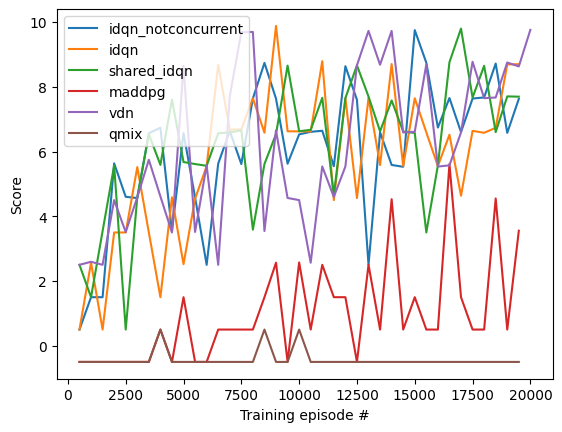

In [85]:
plot_logs([notconcurrent_idqn_logs, idqn_logs, shared_idqn_logs, maddpg_logs, vdn_logs, qmix_logs])